<a href="https://colab.research.google.com/github/ArthurB70/BrainHarmony-code/blob/caio%2FEEG-Nature/EEG_Nature_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import random
import torch.nn.functional as F
import argparse
from sklearn import metrics
from tqdm.notebook import tqdm
import gc
import shutil

## Extração do dataset de teste e treino

In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/TCC/Nature/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/TCC/Nature/test.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

## Definição das labels

In [ ]:
labels = ['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff',
       'Replace', 'BothReleased']

## Adicionando parametros da treino

In [ ]:
torch.manual_seed(2021)
np.random.seed(2021)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=1, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=1024, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.002, help="adam's learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.99, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=1, help="number of cpu threads to use during batch generation")
parser.add_argument("--in_len", type=int, default=2**10, help="length of the input fed to neural net")
parser.add_argument("--in_channels", type=int, default=32, help="number of signal channels")
parser.add_argument("--out_channels", type=int, default=6, help="number of classes")
parser.add_argument("--chunk", type=int, default=1000, help="length of splited chunks")
opt, unknown = parser.parse_known_args()
print(device)

cuda:0


## Criando dataset de treino

Leitura de todos os csv's de treino

In [ ]:
%%time
def read_csv(data, events):
    x = pd.read_csv(data)
    y = pd.read_csv(events)
    id = '_'.join(x.iloc[0, 0].split('_')[:-1])
    x = x.iloc[:,1:].values
    y = y.iloc[:,1:].values
    return x, y


trainset = []
gt = []
for filename in tqdm(os.listdir('./train')):
    if 'data' in filename:
        data_file_name = os.path.join('./train', filename)
        id = filename.split('.')[0]
        events_file_name = os.path.join('./train', '_'.join(id.split('_')[:-1]) + '_events.csv')
        x, y = read_csv(data_file_name, events_file_name)
        trainset.append(x.T.astype(np.float32))
        gt.append(y.T.astype(np.float32))

  0%|          | 0/192 [00:00<?, ?it/s]

CPU times: user 1min 1s, sys: 5.14 s, total: 1min 6s
Wall time: 1min 10s


In [11]:
valid_dataset = trainset[-2:]
valid_gt = gt[-2:]
trainset = trainset[:-2]
gt = gt[:-2]

## Checar pra que serve os loads abaixo

In [12]:
import os
import pandas as pd

# Diretório onde estão os arquivos CSV
pasta = '/content/train'

# Lista para armazenar as médias
medias_por_coluna = []
desvios_por_coluna = []

# Percorre todos os arquivos na pasta
for arquivo in os.listdir(pasta):
    if arquivo.endswith('.csv'):
        # Lê o arquivo CSV
        path_arquivo = os.path.join(pasta, arquivo)
        df = pd.read_csv(path_arquivo)

        # Calcula a média das colunas (exceto a primeira) e a adiciona à lista
        medias = df.iloc[:, 1:].mean()
        medias_por_coluna.append(medias)

        # Calcula o desvio padrão das colunas (exceto a primeira) e o adiciona à lista
        desvios = df.iloc[:, 1:].std()
        desvios_por_coluna.append(desvios)

# Calcula a média geral das médias de todas as colunas
media_geral = pd.concat(medias_por_coluna, axis=1).mean(axis=1)

# Calcula o desvio padrão geral dos desvios padrão de todas as colunas
desvio_padrao_geral = pd.concat(desvios_por_coluna, axis=1).mean(axis=1)

# Imprime a média geral
print("Média Geral das Médias das Colunas:")
print(media_geral)

# Imprime o desvio padrão geral
print("Desvio Padrão Geral dos Desvios Padrão das Colunas:")
print(desvio_padrao_geral)

Média Geral das Médias das Colunas:
Fp1                   141.436174
Fp2                   181.450107
F7                    318.705390
F3                     -3.592243
Fz                     -6.192955
F4                    293.638697
F8                      5.686913
FC5                   296.159811
FC1                    74.503146
FC2                    -0.987177
FC6                   136.283538
T7                     66.464876
C3                    287.724126
Cz                     -4.704870
C4                     91.931601
T8                     69.524847
TP9                    56.688574
CP5                    18.805123
CP1                    40.454588
CP2                    36.563156
CP6                   -56.961592
TP10                  147.960604
P7                    211.674659
P3                     90.464181
Pz                    123.174023
P4                    153.110280
P8                    235.123387
PO9                   -37.774787
O1                    157.268427
Oz     

In [13]:
media_geral_total = sum(media_geral) / len(media_geral)
desvio_geral_total = sum(desvio_padrao_geral) / len(desvio_padrao_geral)

# Imprime a média geral total
print("Média Geral Total:", media_geral_total)

print("Desvio Geral Total:", desvio_geral_total)

Média Geral Total: 80.72183606134142
Desvio Geral Total: 179.64971377523224


In [14]:
# m = np.load('../input/cnn-eeg/mean.npy')
# s = np.load('../input/cnn-eeg/std.npy')

m = media_geral_total
s = desvio_geral_total

## Função para descartar dados irrelevantes e splitar sinais de longa duração em partes

In [15]:
def resample_data(gt, chunk_size=opt.chunk):
    """
    split long signals to smaller chunks, discard no-events chunks
    """
    total_discard_chunks = 0
    mean_val = []
    threshold = 0.01
    index = []

    for i in range(len(gt)):
        for j in range(0, gt[i].shape[1], chunk_size):
            mean_val.append(np.mean(gt[i][:, j:min(gt[i].shape[1],j+chunk_size)]))
            if mean_val[-1] < threshold:  # discard chunks with low events time
                total_discard_chunks += 1
            else:
                index.extend([(i, k) for k in range(j, min(gt[i].shape[1],j+chunk_size))])

    plt.plot([0, len(mean_val)], [threshold, threshold], color='r')
    plt.scatter(range(len(mean_val)), mean_val, s=1)
    plt.show()
    print('Total number of chunks discarded: {} chunks'.format(total_discard_chunks))
    print('{}% data'.format(total_discard_chunks/len(mean_val)))
    del mean_val
    gc.collect()
    return index

# Classe para montar o dataset

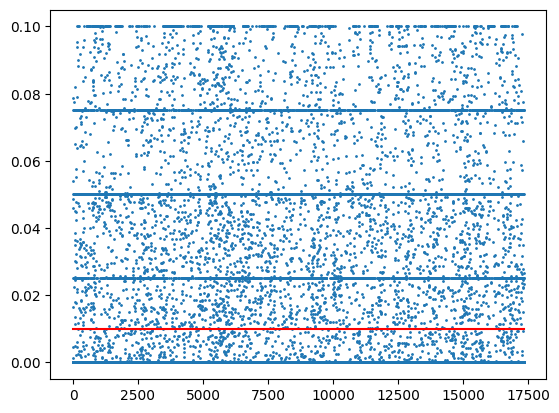

Total number of chunks discarded: 8645 chunks
0.4983283375605257% data
8703000
CPU times: user 2.95 s, sys: 424 ms, total: 3.38 s
Wall time: 3.58 s


In [16]:
%%time
class EEGSignalDataset(Dataset):
    def __init__(self, data, gt, m=m, s=s, soft_label=True, train=True):
        self.data = data
        self.gt = gt
        self.train = train
        self.soft_label = soft_label
        self.eps = 1e-7
        if train:
            self.index = resample_data(gt)
        else:
            self.index = [(i, j) for i in range(len(data)) for j in range(data[i].shape[1])]
        for dt in self.data:
            dt -= m
            dt /= s+self.eps

    def __getitem__(self, i):
        i, j = self.index[i]
        raw_data, label = self.data[i][:,max(0, j-opt.in_len+1):j+1], \
                self.gt[i][:,j]

        pad = opt.in_len - raw_data.shape[1]
        if pad:
            raw_data = np.pad(raw_data, ((0,0),(pad,0)), 'constant',constant_values=0)

        raw_data, label = torch.from_numpy(raw_data.astype(np.float32)),\
                            torch.from_numpy(label.astype(np.float32))
        if self.soft_label:
            label[label < .02] = .02
        return raw_data, label


    def __len__(self):
        return len(self.index)

dataset = EEGSignalDataset(trainset, gt)
dataloader = DataLoader(dataset, batch_size = opt.batch_size,\
                                       num_workers = opt.n_cpu, shuffle=True)
print(len(dataset))

# Criação da arquitetura da rede

In [17]:
class NNet(nn.Module):
    def __init__(self, in_channels=opt.in_channels, out_channels=opt.out_channels):
        super(NNet, self).__init__()
        self.hidden = 32
        self.net = nn.Sequential(
            nn.Conv1d(opt.in_channels, opt.in_channels, 5, padding=2),
            nn.Conv1d(self.hidden, self.hidden, 16, stride=16),
            nn.LeakyReLU(0.1),
            nn.Conv1d(self.hidden, self.hidden, 7, padding=3),
        )
        for i in range(6):
            self.net.add_module('conv{}'.format(i), \
                                self.__block(self.hidden, self.hidden))
        self.net.add_module('final', nn.Sequential(
            nn.Conv1d(self.hidden, out_channels, 1),
            nn.Sigmoid()
        ))

    def __block(self, inchannels, outchannels):
        return nn.Sequential(
            nn.MaxPool1d(2, 2),
            nn.Dropout(p=0.1, inplace=True),
            nn.Conv1d(inchannels, outchannels, 5, padding=2),
            nn.LeakyReLU(0.1),
            nn.Conv1d(outchannels, outchannels, 5, padding=2),
            nn.LeakyReLU(0.1),
        )

    def forward(self, x):
        return self.net(x)

# Treino

In [18]:
nnet = NNet()
nnet.to(device)
loss_fnc = nn.BCELoss()
adam = optim.Adam(nnet.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
loss_his, train_loss = [], []
nnet.train()
for epoch in range(opt.n_epochs):
    p_bar = tqdm(dataloader)
    for i, (x, y) in enumerate(p_bar):
        x, y = x.to(device), y.to(device)
        pred = nnet(x)
        loss = loss_fnc(pred.squeeze(dim=-1), y)
        adam.zero_grad()
        loss.backward()
        adam.step()
        train_loss.append(loss.item())
        p_bar.set_description('[Loss: {}]'.format(train_loss[-1]))
        if i % 50 == 0:
            loss_his.append(np.mean(train_loss))
            train_loss.clear()
    print('[Epoch {}/{}] [Loss: {}]'.format(epoch+1, opt.n_epochs, loss_his[-1]))

torch.save(nnet.state_dict(), 'model.pt')

  0%|          | 0/8500 [00:00<?, ?it/s]

[Epoch 1/1] [Loss: 0.1750419878959656]


In [19]:
testset = EEGSignalDataset(valid_dataset, valid_gt, train=False, soft_label=False)
testloader = DataLoader(testset, batch_size = opt.batch_size,\
                                       num_workers = opt.n_cpu, shuffle=False)
nnet.eval()
y_pred = []
with torch.no_grad():
    for x, _ in tqdm(testloader):
        x = x.to(device)
        pred = nnet(x).detach().cpu().numpy()
        y_pred.append(pred)

  0%|          | 0/400 [00:00<?, ?it/s]

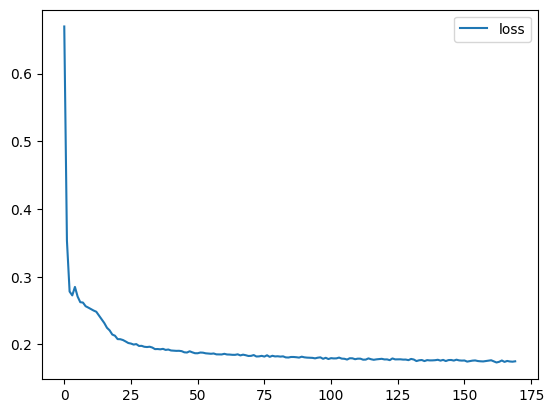

In [21]:
plt.plot(range(len(loss_his)), loss_his, label='loss')
plt.legend()
plt.show()

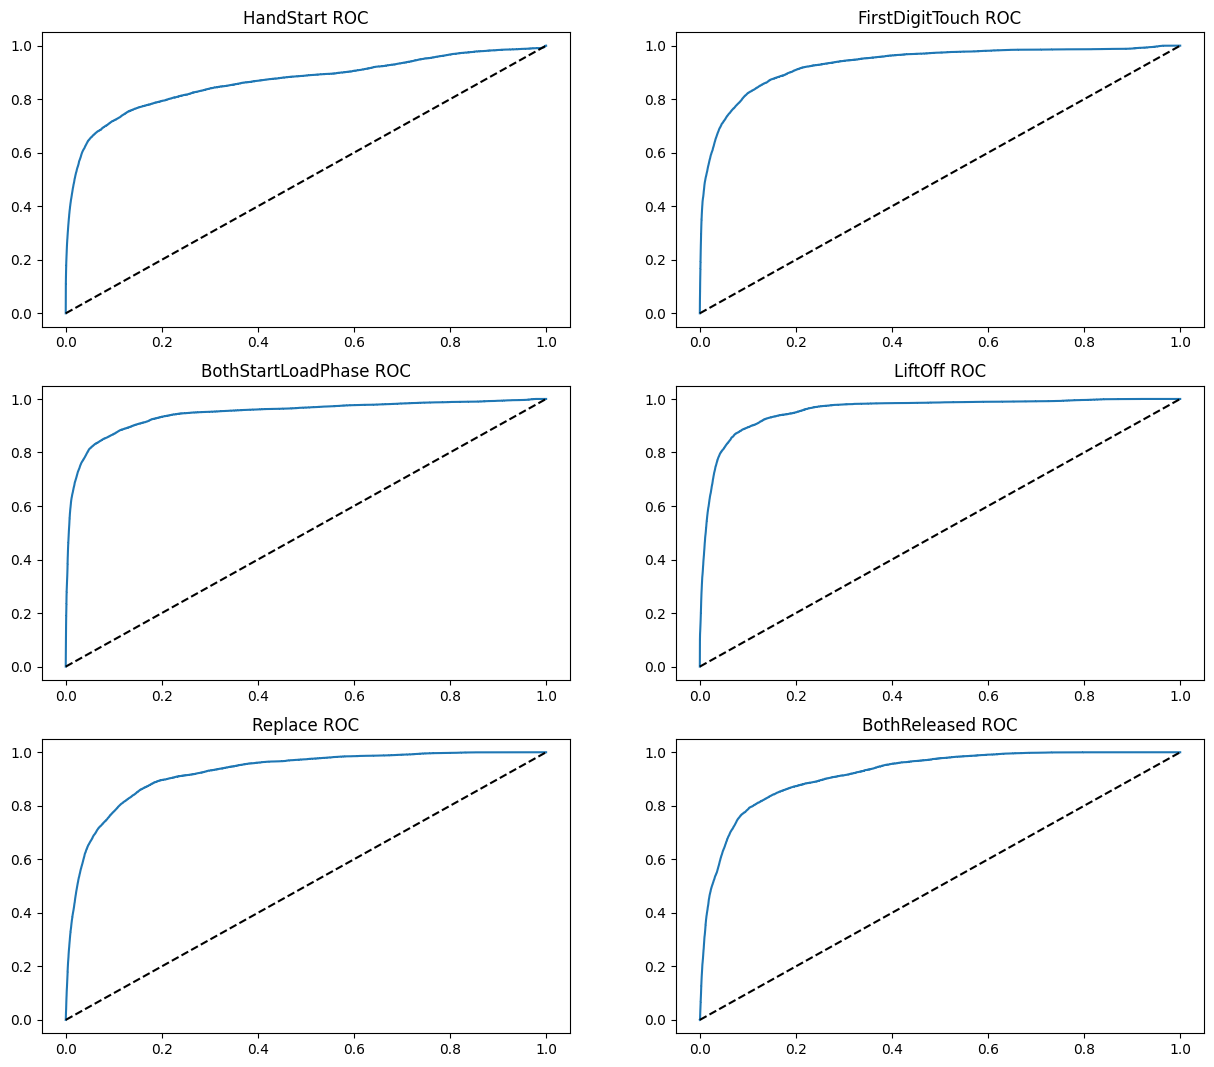

auc roc:  0.9240349384190262


In [20]:
def plot_roc(y_true, y_pred):
    fig, axs = plt.subplots(3, 2, figsize=(15,13))
    for i, label in enumerate(labels):
        fpr, tpr, _ = metrics.roc_curve(y_true[i], y_pred[i])
        ax = axs[i//2, i%2]
        ax.plot(fpr, tpr)
        ax.set_title(label+" ROC")
        ax.plot([0, 1], [0, 1], 'k--')

    plt.show()

y_pred = np.concatenate(y_pred, axis=0).squeeze(axis=-1)
valid_gt = np.concatenate(valid_gt, axis=1)
plot_roc(valid_gt, y_pred.T)
print('auc roc: ', metrics.roc_auc_score(valid_gt.T, y_pred))

plt.plot(range(len(loss_his)), loss_his, label='loss')
plt.legend()
plt.show()

In [23]:
del y_pred
del testset
del testloader
del valid_dataset
del valid_gt
gc.collect()

0

# Base de Teste

In [24]:
y_pred = []
y_true = []
with torch.no_grad():
    for x, y in tqdm(dataloader):
        x = x.to(device)
        pred = nnet(x).squeeze(dim=-1).detach().cpu().numpy()
        y_pred.append(pred)
        y_true.append(y)

  0%|          | 0/8500 [00:00<?, ?it/s]

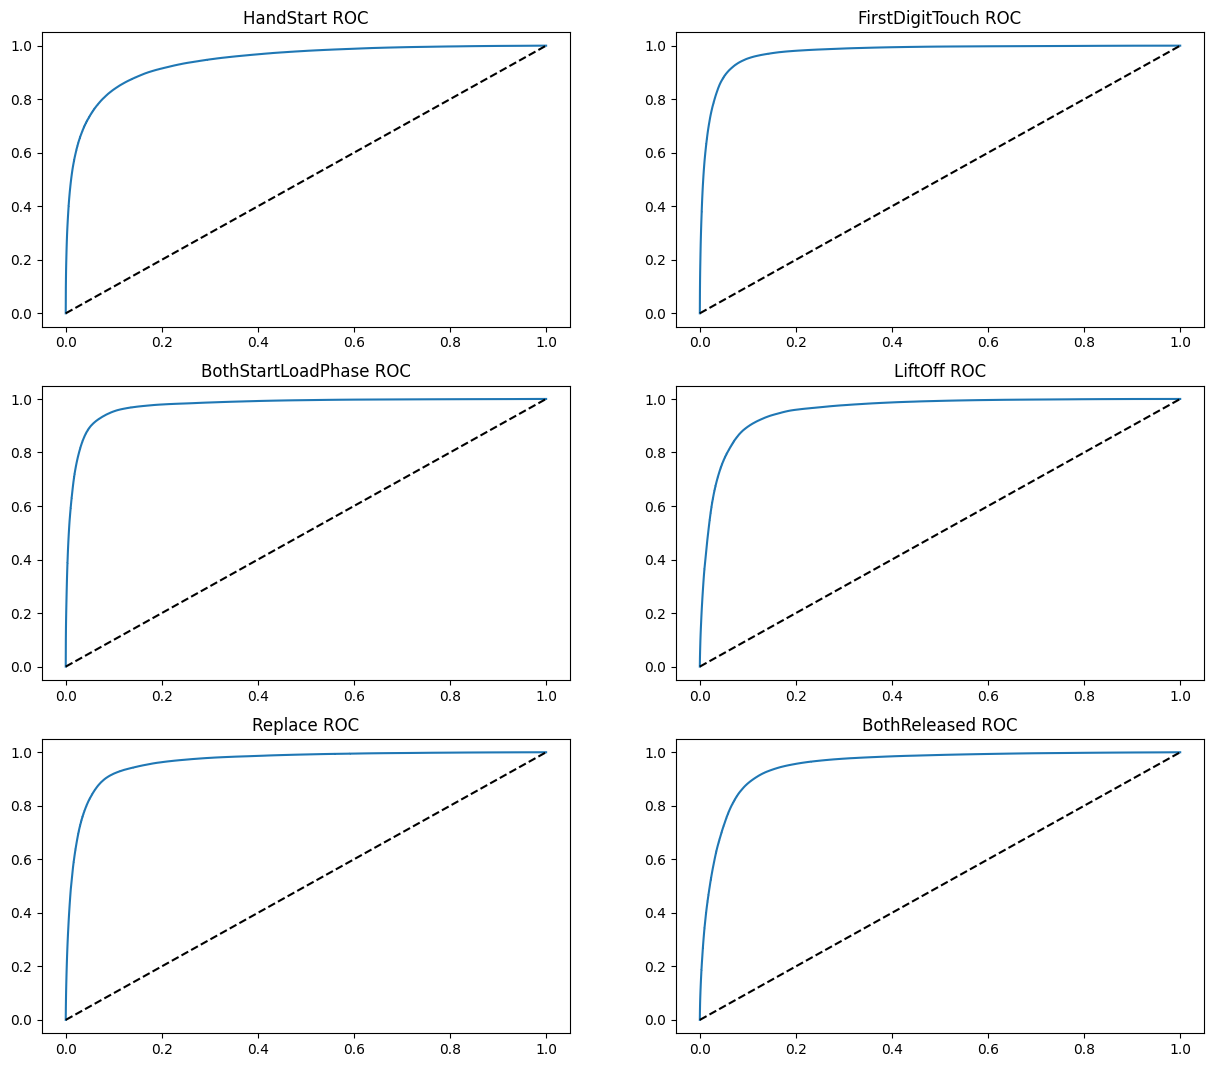

auc roc:  0.9602634791075683


In [25]:
y_pred = np.concatenate(y_pred, axis=0)
y_true = np.concatenate(y_true, axis=0)
y_true[y_true<.1]=0
plot_roc(y_true.T, y_pred.T)
print('auc roc: ', metrics.roc_auc_score(y_true, y_pred))

In [26]:
i = 1231
with torch.no_grad():
    input = dataset[i][0].unsqueeze(dim=0)
    print(nnet(input.to(device)))
    print(dataset[i][1])

tensor([[[0.0319],
         [0.1449],
         [0.1205],
         [0.0744],
         [0.0183],
         [0.0195]]], device='cuda:0')
tensor([0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200])


In [27]:
del y_pred
del y_true
del dataset
del dataloader
del trainset
del gt
gc.collect()

19624